In [1]:
%load_ext autoreload
import swm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def consistent_fig():
    return plt.figure(figsize=(10, 10))

# Section 2

$$\begin{aligned}
C(X_r, X_s) =& \frac{\sqrt{\frac{1}{n}\sum_{i=1}^n\left[x_r(i) - x_s(i)\right]^2}}{\sqrt{\frac{1}{n}\sum_{i=1}^nx_r(i)^2} + \sqrt{\frac{1}{n}\sum_{i=1}^nx_s(i)^2}} \\
=& \frac{\sqrt{\phantom{\frac{1}{n}}\sum_{i=1}^n\left[x_r(i) - x_s(i)\right]^2}}{\sqrt{\phantom{\frac{1}{n}}\sum_{i=1}^nx_r(i)^2} + \sqrt{\phantom{\frac{1}{n}}\sum_{i=1}^nx_s(i)^2}}
\end{aligned}$$

## Benchmark problem

Two parallel plots have the same trend. But, they end up showing maximally inconsistent by TIC.

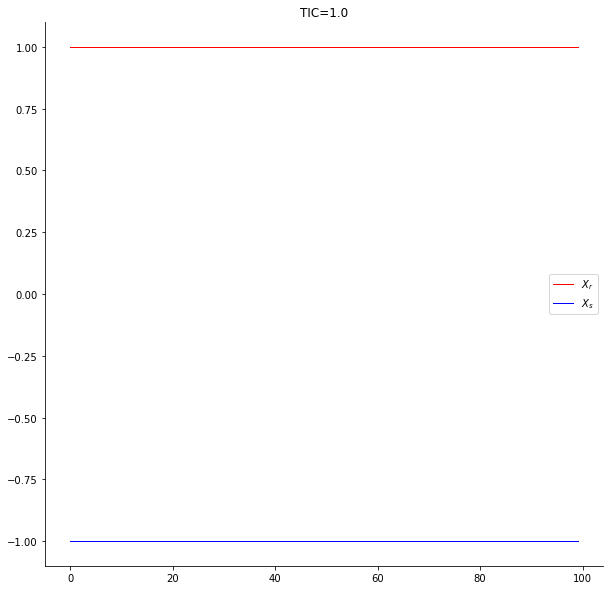

In [2]:
consistent_fig()

n = 100
x_r = np.ones(n)
x_s_hflip = -x_r
tic = swm.tic(x_r, x_s_hflip)
plt.plot(x_r, label='$X_r$', color='red', lw=1)
plt.plot(x_s_hflip, label='$X_s$', color='blue', lw=1)
plt.title(f"TIC={tic}")
sns.despine()
plt.legend();

This applies generally -- TIC can't adapt to translations. And, worse than that, the variance adjustments in the denominator make it so translations of the same magnitude but different signs have different scores.

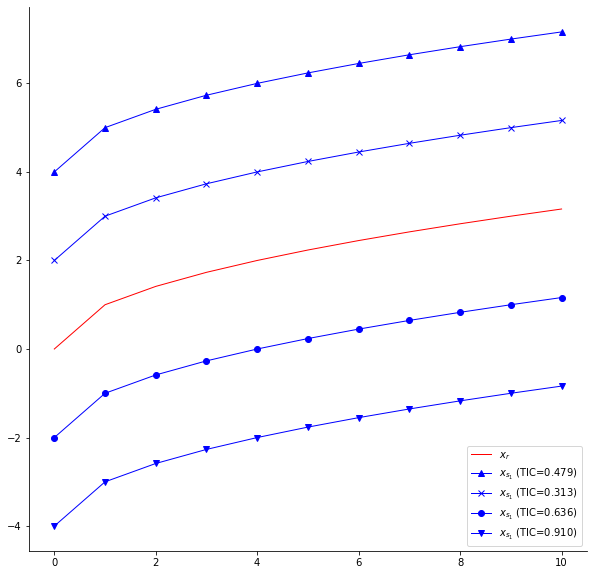

In [3]:
consistent_fig()


np.random.seed(100)
n = 11
c = 1
x_r = np.sqrt(np.arange(n))
plt.plot(x_r, label='$x_r$', color='red', lw=1)

for marker, translation in zip("^xov", [4, 2, -2, -4]):
    x_s = x_r + translation
    tic = swm.tic(x_r, x_s)
    plt.plot(x_s, label='$x_{s_1}$ ' + f'(TIC={tic:0.3f})', color='blue', marker=marker, lw=1)

sns.despine()
plt.legend();

## Trend Problem

Even if the trends are maximally inconsistent, TIC can't pick it up, showing a (relatively) better score,

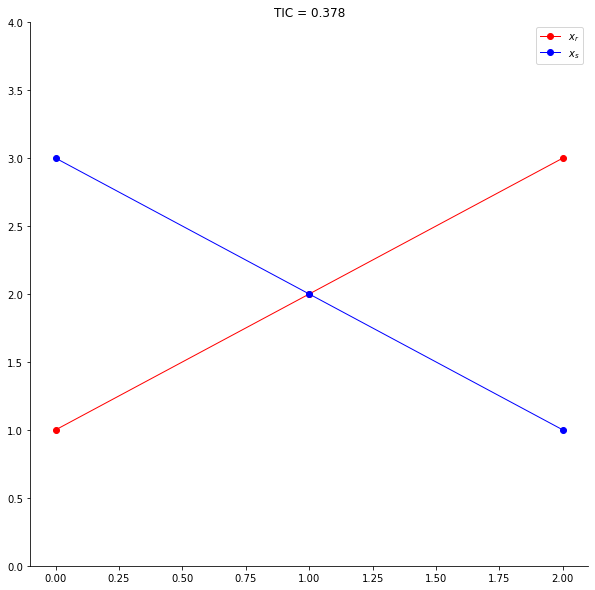

In [4]:
consistent_fig()


np.random.seed(100)
n = 100
c = 1
x_r = np.arange(3)+1
x_s = -(x_r - 4)

tic = swm.tic(x_r, x_s)

plt.plot(x_r, label='$x_{r}$', marker='o', color='red', lw=1)
plt.plot(x_s, label='$x_{s}$', marker='o', color='blue', lw=1)
plt.ylim(0, 4)
sns.despine()
plt.title(f"TIC = {tic:0.3f}")
plt.legend();

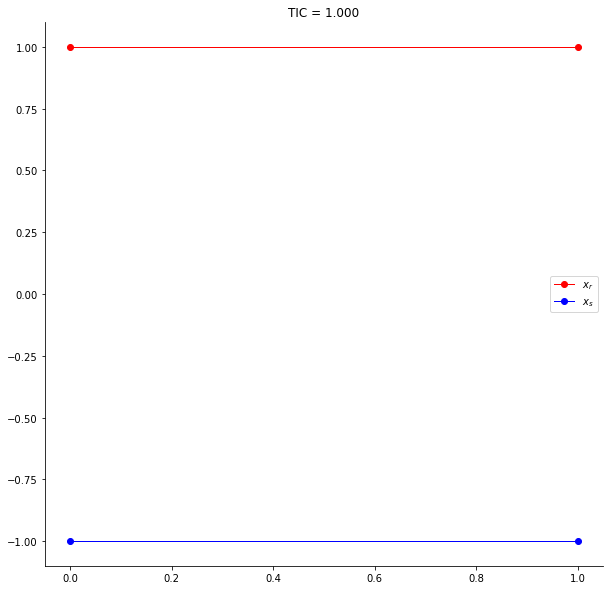

In [5]:
consistent_fig()


np.random.seed(100)
n = 100
c = 1
x_r_prime = np.diff(x_r)
x_s_prime = np.diff(x_s)

tic = swm.tic(x_r_prime, x_s_prime)

plt.plot(x_r_prime, label='$x_{r}$', marker='o', color='red', lw=1)
plt.plot(x_s_prime, label='$x_{s}$', marker='o', color='blue', lw=1)
sns.despine()
plt.title(f"TIC = {tic:0.3f}")
plt.legend();

# Simulation Model Validation Method

The metric they derived (2)

$$C(X_r, X_s) =
\left\{
	\begin{array}{ll}
		\frac{\sqrt{\sum_{i=1}^n \left[x_r(i) - x_s(i)\right]^2}}{\sqrt{\sum_{i=1}^n x_r(i)^2}}  & \mbox{if } \sqrt{\sum_{i=1}^n x_r(i)^2} \ne 0 \\
		\sqrt{\sum_{i=1}^n x_s(i)^2} & \mbox{if } \sqrt{\sum_{i=1}^n x_r(i)^2}  = 0
	\end{array}
\right.$$

confuses me a little. If the sum of squares for $x_r$ is zero as in the lower equation's condition, then it's just a line at 0. I'm not sure why you would want to compare the simulation output to what is essentially no action. (Maybe some robotics domain knowledge that I'm missing?)

Also, the $\xi$ is essentially acting as a temperature parameter in,

$$D(X_r, X_s) = e^{-\xi C(X_r, X_s)}$$

to squash the new metric to $(0, 1)$. They say it is,

> set by domain expert according to the purpose of simulation application

so it's not as useful as TIC in that now there is a hyper-parameter to select. It's also a bit annoying in that their squashing function flipped the interpretability: Now close to 1 is a good match; before it mean maximally different.

### Minor error

There are multiple errors in their equation (4) and (5). They have, 

$$\begin{aligned}
X'_r &= \langle x'_r(2), x'_r(2), \dots, x'_r(n-1)\rangle = \left\langle \frac{x_r(2) - x_r(1)}{\Delta t} + \frac{x_r(3) - x_r(2)}{\Delta t} + \cdots + \frac{x_r(n) - x_r(n-1)}{\Delta t} \right\rangle \\
X'_s &= \langle x'_s(2), x'_s(2) \dots, x'_s(n-1)\rangle = \left\langle \frac{x_s(2) - x_s(1)}{\Delta t} + \frac{x_s(3) - x_s(2)}{\Delta t} + \cdots + \frac{x_s(n) - x_s(n-1)}{\Delta t} \right\rangle \\
\end{aligned}$$

it should be,

$$\begin{aligned}
X'_r &= \langle x'_r(2), x'_r(3), \dots, x'_r(n)\rangle = \left\langle \frac{x_r(2) - x_r(1)}{\Delta t} + \frac{x_r(3) - x_r(2)}{\Delta t} + \cdots + \frac{x_r(n) - x_r(n-1)}{\Delta t} \right\rangle \\
X'_s &= \langle x'_s(2), x'_s(3), \dots, x'_s(n)\rangle = \left\langle \frac{x_s(2) - x_s(1)}{\Delta t} + \frac{x_s(3) - x_s(2)}{\Delta t} + \cdots + \frac{x_s(n) - x_s(n-1)}{\Delta t} \right\rangle \\
\end{aligned}$$

So basically, take the rate of change for each observation in the reference and simulation, use that for the "trends" series, too. 

## Integration of position conformity and trend conformity

This section assumes a set of simulation outputs, 

$$O_s = \{X_{s1}, X_{s2}, \dots, X_{sp} \}$$

which they use to construct a matrix,

$$A = \begin{bmatrix}
a_{11} & a_{12} \\
a_{12} & a_{22} \\
\vdots & \vdots \\
a_{p1} & a_{p2} \\
\end{bmatrix}$$

with, 

$$\begin{aligned}
a_{i1} &= D(X_r, X_{si}) \\
a_{i1} &= T(X_r, X_{si})
\end{aligned}$$

So the first column is the improved and squashed TIC on position and the second is on trend. They then translate A into S by,

$$s_{ij} = \frac{a_{ij}}{\bar{a}_{\mathbf{\bullet} j}} $$

where $$a_{\mathbf{\bullet} j} = \sum_{k=1}^p \frac{a_{kj}}{p}$$

So, both columns are now in column-mean units. 

$$S = \begin{bmatrix}
s_{11} & s_{12} \\
s_{12} & s_{22} \\
\vdots & \vdots \\
s_{p1} & s_{p2} \\
\end{bmatrix}$$


**Here's where the presentation gets a little weird for me.**

They define,

$$y = k_1s_1 + k_2s_2$$

which you can use to select the best simulation. It's a linear combination of the squashed/improved TIC metric on the position and trend, respectively. They further define, 

$$k_1^2 + k_2^2 = 1$$

so that $k$, the weights, represent a unit-vector. That would be a requirement of PCA. (I'm not sure why it would be mean centered (via division) versus mean-shifted so it was zero).

But, here's the thing -- this whole section just derives PCA. See Replication section below.

# Application

They give the expected A matrix via Table 2 and 3.

In [6]:
expected_D_col = np.array([0.729, 0.733, 0.663, 0.813, 0.840, 0.724, 0.69, 0.555, 0.8])
expected_T_col = np.array([1, 0.05, 1, 0.517, 0.730, 0.652, 0.368, .185, .192])
expected_A = np.vstack([expected_D_col, expected_T_col]).T
expected_A.T

array([[0.729, 0.733, 0.663, 0.813, 0.84 , 0.724, 0.69 , 0.555, 0.8  ],
       [1.   , 0.05 , 1.   , 0.517, 0.73 , 0.652, 0.368, 0.185, 0.192]])

But they don't give the data used for Fig 3. I think this is *close* to correct.

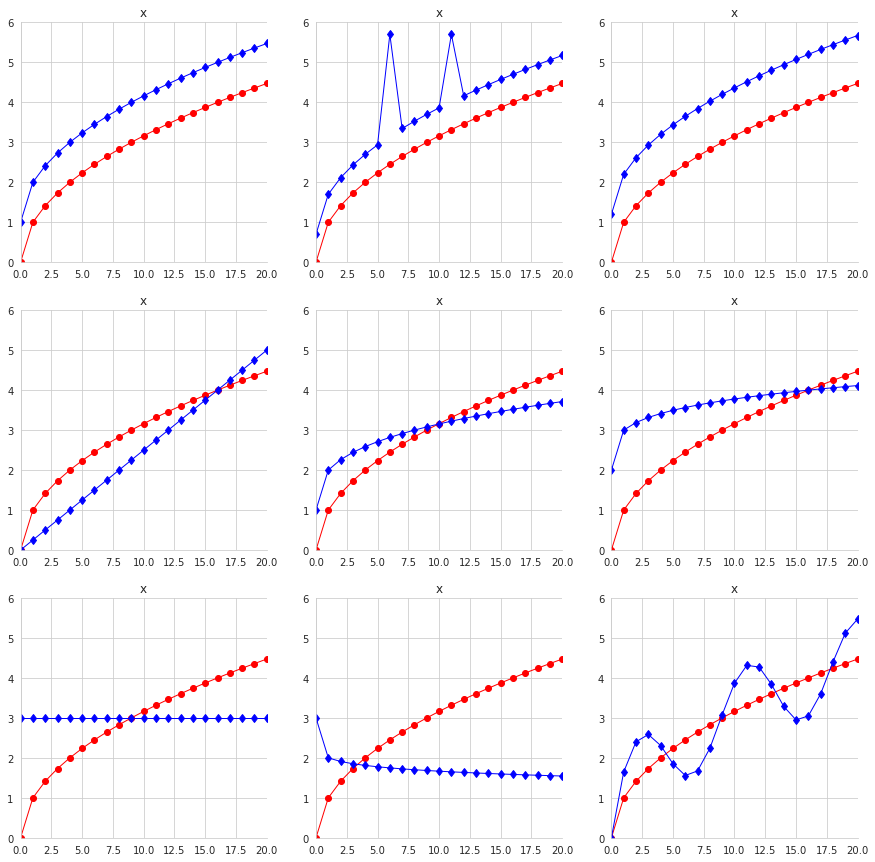

In [9]:
t = np.arange(21)

x_sqrt = np.sqrt(t)
X_r = x_sqrt
two_spikes = x_sqrt.copy() + 0.7
two_spikes[6] = 5.7
two_spikes[11] = 5.7

simulations = []
simulations.append(('a', x_sqrt+1))
simulations.append(('b', two_spikes))
simulations.append(('c', x_sqrt+1.2))
simulations.append(('d', t * 5/20))
simulations.append(('e', t**(1/3)+1))
simulations.append(('f', t**(1/4)+2))
simulations.append(('g', 2 + np.ones_like(x_sqrt)))
simulations.append(('e', 2 + -t**(1/8)+1))
simulations.append(('f', x_sqrt + np.sin(2*np.pi * t/20 * 2.25)))

fig = plt.figure(figsize=(15, 15))

sns.set_style('whitegrid')

shared_ax = None
i = 1
for l, X_s in simulations:
    if i == 1:
        ax = fig.add_subplot(3, 3, i)
        shared_ax = ax
        plt.xlim((0, 20))
        plt.ylim((0, 6))
    else:
        ax = fig.add_subplot(3, 3, i, sharex=ax, sharey=ax)
    
    
    plt.plot(t, X_r, marker='o', color='red', lw=1)
    plt.plot(t, X_s, marker='d', color='blue', lw=1)
    
    plt.title("x")
    sns.despine()
    i += 1

The also don't give their $\xi$. Using the deduced data set, it seems like $\xi=1$,

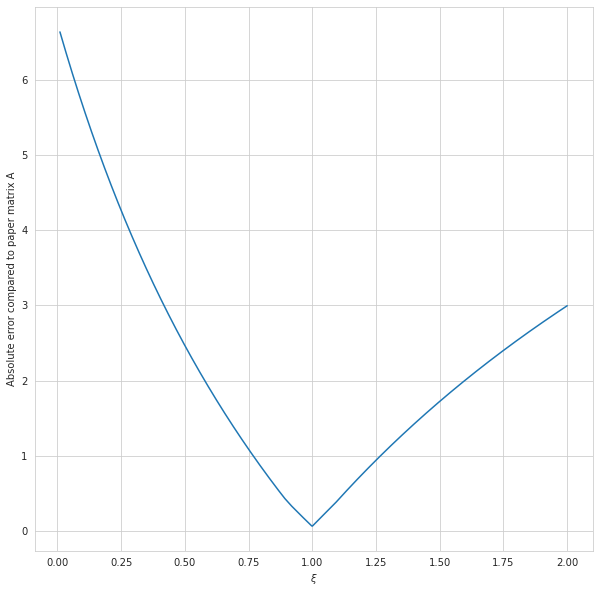

In [10]:
consistent_fig()

ξ_space = np.linspace(0.01, 2, 2001)
scores = []
for ξ in ξ_space:
    A = swm.make_matrix_A(x_sqrt, [x_s for _, x_s in simulations], ξ)
    ϵ = np.abs(expected_A - A).sum()
    scores.append(ϵ)
    
plt.plot(ξ_space, scores)
plt.xlabel(r'$\xi$')
plt.ylabel('Absolute error compared to paper matrix A');

## Replication

The "paydirt" of all of this is supposed to be equation (18) which they have as,

$$y = 0.0223s_1 + 0.9998s_2$$

What is this? It the projection of matrix $S$ onto the first principle component of S. I'm not sure why they felt compelled to derive the whole thing. The only difference is how they center it. 

The most obvious way to show this? Using the data from above,

In [11]:
S = swm.make_matrix_S(x_sqrt, [x_s for _, x_s in simulations], ξ)

In [12]:
S

array([[0.993782  , 2.62184679],
       [0.93101231, 0.0037862 ],
       [0.8757028 , 2.62184679],
       [1.23703287, 0.70056401],
       [1.31985196, 1.39639335],
       [0.98078502, 1.11598128],
       [0.88953343, 0.35482838],
       [0.57627346, 0.08927504],
       [1.19602616, 0.09547816]])

Here is the PCA according to sklearn,

In [13]:
from sklearn.decomposition import PCA

# Create a PCA estimator.
# (We only care about the 1st principle component)
pca = PCA(1)

# Fit it on S
pca.fit(S)

# Recover the principle components.
# These are the k_1 and k_2 in their paper.
k_ = pca.components_[0] 
k_

array([0.02330268, 0.99972846])

That's it. 

Or, "by hand,"

In [14]:
# Get covariance matrix as per (12)
V = np.cov(S.T)

# Get eigen values and vectors
# That's what they get to in Equation (16) 
λ, k = np.linalg.eig(V)

# Get the biggest eigenvalue
i = np.argmax(λ)

# Select the associated eigenvector
k = k[:, 1]
k

array([-0.02330268, -0.99972846])

This is different only in sign. But, it's an eigenvector, so it's a unit vector,

In [15]:
(k**2).sum()

1.0

and as such, it's only the vector that matters. If both of the weights are negative, you can negatate them, it doesn't change the mathematical object in this context. 

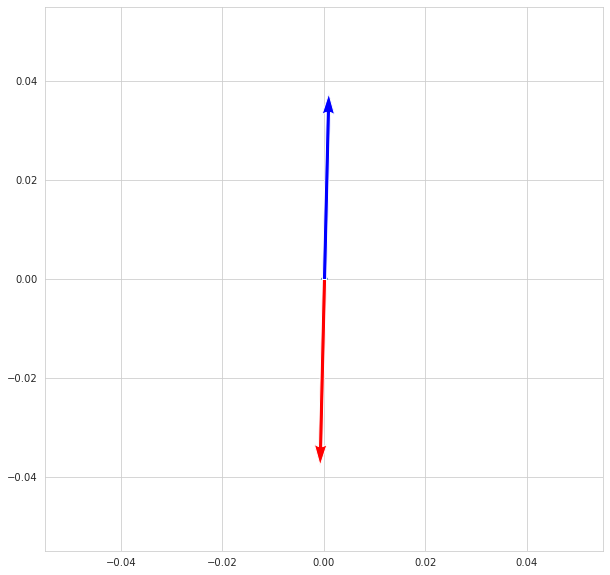

In [16]:
consistent_fig()

plt.scatter([0], [0], marker=10)
plt.quiver(*k, scale=3, lw=1, color='red')
plt.quiver(*k_, scale=3, lw=1, color='blue');

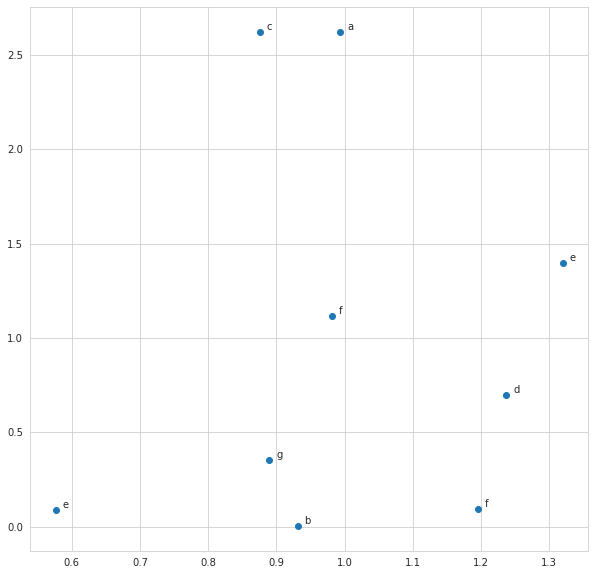

In [17]:
consistent_fig()
ax = plt.gca()

ax.scatter(S[:, 0], S[:, 1]);

for i, label in enumerate(c for c, _ in simulations):
    ax.annotate(label, S[i, :] + np.array([0.01, 0.01]))

In [18]:
y = S @ k_
y

array([2.64429262, 0.02548026, 2.64154106, 0.72919996, 1.42677026,
       1.13853317, 0.37546054, 0.10267952, 0.12332285])

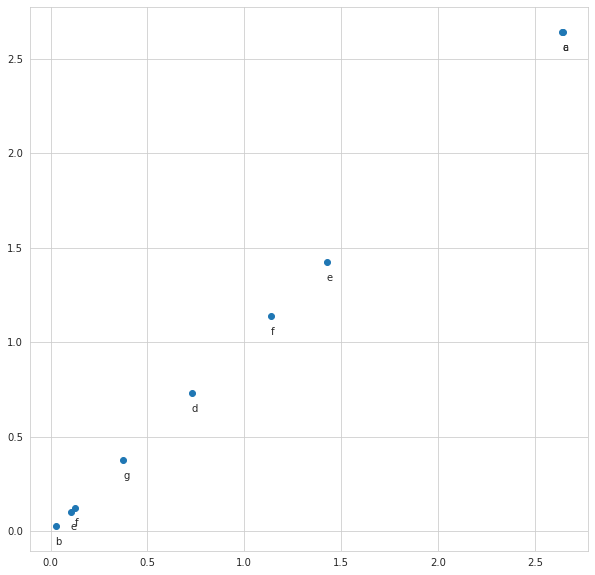

In [19]:
consistent_fig()
ax = plt.gca()

y = S @ k_

ax.scatter(y, y);

for i, label in enumerate(c for c, _ in simulations):
    ax.annotate(label, np.array([y[i], y[i]]) + np.array([0.0, -0.1]))

In [20]:
df = pd.DataFrame({'y': y}, index=list('abcdefghi'))
df['result'] = df['y'].rank(ascending=False)
df.T

,a,b,c,d,e,f,g,h,i
y,2.644293,0.02548,2.641541,0.7292,1.42677,1.138533,0.375461,0.10268,0.123323
result,1.000000,9.00000,2.000000,5.0000,3.00000,4.000000,6.000000,8.00000,7.000000


Or, using the replicated package, 

In [25]:
y = swm.compute_y(x_sqrt, [x_s for _, x_s in simulations], ξ)
y

array([2.64429262, 0.02548026, 2.64154106, 0.72919996, 1.42677026,
       1.13853317, 0.37546054, 0.10267952, 0.12332285])

In [27]:
y.argmax() # Best model by row index in S

0